Pràctica: Projecto 3. Generación de números escritos a mano mediante una GAN

Autores: Bo Miquel Nordfeldt, Joan Muntaner, Helena Antich

Fecha: Mayo 2021

# Generative Adversarial Network

## Librerías y descarga de datos

In [13]:
#Importamos librerías que necesitamos

%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl

In [14]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

## Visualización de los datos

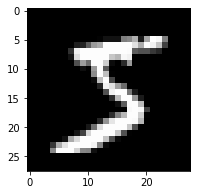

In [15]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Definición del modelo

### Discriminador

In [16]:
# Definimos la clase que generará la red neuronal artifical encargada de discriminar si los datos son reales o falsos.

class Discriminator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal). 
    
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        
        super(Discriminator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene muchas neuronas en las
        # primeras capas y que va disminuyendo, de tamaño, paulativamente. 
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim * 8)  
        self.capa_oculta2 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.capa_oculta3 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.capa_oculta4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.capa_output = nn.Linear(hidden_dim, output_size)
        
        self.p = p 

    # Definimos la función feedforward de la red
    def forward(self, x):
        
        # Aplanamos la imagen (que esta en formato de tensor) mediante la función view de pytorch.
        x = x.view(-1,28*28)
        # x = x.flatten(28*28)        
        
        # Pasamos la imagen aplanada por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido de pasar la imagen por la función de propagación lineal le aplicamos 
        # la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta4(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Pasamos la imagen por la capa de salida sin aplicarle, aún, la función de activación (tal y como
        # indica el enunciado).
        x = self.capa_output(x)

        return x


### Generador

In [17]:
# Definimos la clase que generará la red neuronal artifical que generará datos falsos.

class Generator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal).
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        super(Generator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene pocas neuronas en las
        # primeras capas y que va aumentando, de tamaño, paulativamente.
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim)
        self.capa_oculta2 = nn.Linear(hidden_dim , hidden_dim * 2)
        self.capa_oculta3 = nn.Linear(hidden_dim * 2 , hidden_dim * 4)
        self.capa_oculta4 = nn.Linear(hidden_dim * 4 , hidden_dim * 8)
        self.capa_salida = nn.Linear(hidden_dim * 8, output_size)
        
        self.p = p
    
    # Definimos la función feedforward de la red.
    def forward(self, x):

        # Pasamos los datos (imágenes) por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido por pasar los datos por la función de propagación lineal de cada red le
        # aplicamos la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta4(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Al resultado de aplicar la capa de salida (función de propagación lineal) a los datos le aplicamos 
        # la función de la tangente hiperbólica como función de activación.
        x = torch.tanh(self.capa_salida(x))
                
        return x
    

### Hiper-parámetros del modelo

In [18]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 32

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 32

# Probabilidad de dropout
p = 0.25

### Compilamos el modelo


In [19]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=256, bias=True)
  (capa_oculta2): Linear(in_features=256, out_features=128, bias=True)
  (capa_oculta3): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=32, bias=True)
  (capa_output): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=32, bias=True)
  (capa_oculta2): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=128, bias=True)
  (capa_oculta4): Linear(in_features=128, out_features=256, bias=True)
  (capa_salida): Linear(in_features=256, out_features=784, bias=True)
)


---
## Coste del discriminador y el generador

In [20]:
# Calculate losses

def real_loss(D_out, smooth):
    
    batch_size = D_out.size(0)
    
    if smooth is True:
        
        etiquetas = torch.ones(batch_size) * 0.9
        
    else:
        
        etiquetas = torch.ones(batch_size)
        
    funcion_coste = nn.BCEWithLogitsLoss()
    
    loss = funcion_coste(D_out.squeeze(), etiquetas)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)

    etiquetas = torch.zeros(batch_size) 

    funcion_coste = nn.BCEWithLogitsLoss()
    
    loss = funcion_coste(D_out.squeeze(), etiquetas)

    return loss

## Optimizadores


In [21]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training de la primera prueba

Recodemos:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.25
- Epocas 50
- Lerning rate de 0.002


In [22]:
# training hyperparams
num_epochs = 50 

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Train with real images
        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3767 | g_loss: 0.7816
Epoch [    1/   50] | d_loss: 0.9601 | g_loss: 6.8752
Epoch [    1/   50] | d_loss: 0.8683 | g_loss: 2.1509
Epoch [    2/   50] | d_loss: 1.0820 | g_loss: 2.5595
Epoch [    2/   50] | d_loss: 0.6707 | g_loss: 3.5321
Epoch [    2/   50] | d_loss: 0.7947 | g_loss: 2.4273
Epoch [    3/   50] | d_loss: 0.9669 | g_loss: 1.5831
Epoch [    3/   50] | d_loss: 0.5575 | g_loss: 4.0546
Epoch [    3/   50] | d_loss: 0.6495 | g_loss: 5.3955
Epoch [    4/   50] | d_loss: 0.7880 | g_loss: 2.0830
Epoch [    4/   50] | d_loss: 0.6046 | g_loss: 3.5522
Epoch [    4/   50] | d_loss: 0.7443 | g_loss: 2.4936
Epoch [    5/   50] | d_loss: 0.7264 | g_loss: 2.0899
Epoch [    5/   50] | d_loss: 0.7173 | g_loss: 3.6897
Epoch [    5/   50] | d_loss: 0.8126 | g_loss: 1.7891
Epoch [    6/   50] | d_loss: 1.0573 | g_loss: 2.0842
Epoch [    6/   50] | d_loss: 1.1793 | g_loss: 1.3924
Epoch [    6/   50] | d_loss: 1.1784 | g_loss: 1.4984
Epoch [    7/   50] | d_loss

### Training loss

Vamos a plotear la evolución del coste durante el entrenamiento

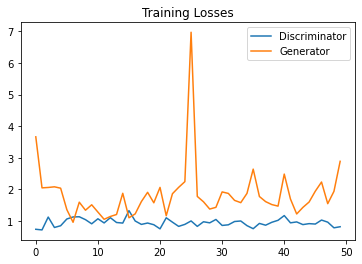

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

BMNF: Creo que esto esta mal REVISAR!!!!!!!!!!

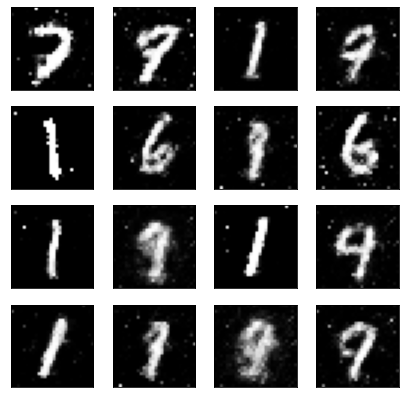

In [27]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Seguidamente se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas. 

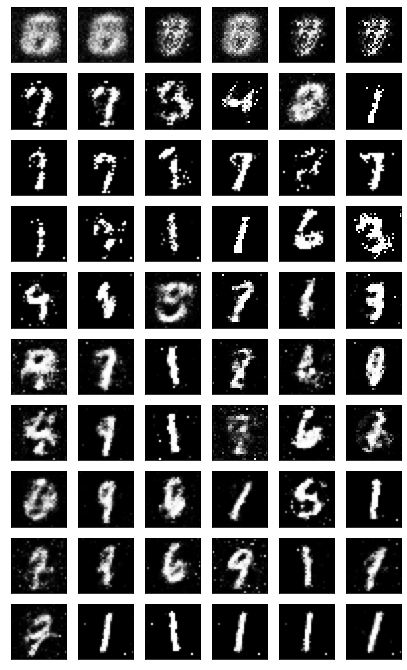

In [28]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

### Nuevas imágenes generadas por el generador


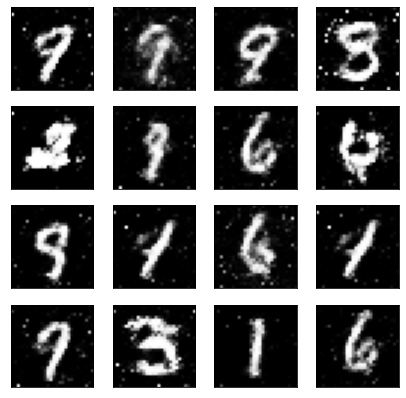

In [29]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

### Conclusiones de la primera prueba

Tenemos un error bastante alto de entrenamiento tanto en la red discriminadora como en la red generadora. Además los números que produce la red generadora no son demasiado buenos, debemos seguir haciendo pruebas.

---

## Training de la segunda prueba

Vamos a usar:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.35
- Epocas 60
- Lerning rate de 0.002

In [67]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 32

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 32

# Probabilidad de dropout
p = 0.35

In [68]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=256, bias=True)
  (capa_oculta2): Linear(in_features=256, out_features=128, bias=True)
  (capa_oculta3): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=32, bias=True)
  (capa_output): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=32, bias=True)
  (capa_oculta2): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=128, bias=True)
  (capa_oculta4): Linear(in_features=128, out_features=256, bias=True)
  (capa_salida): Linear(in_features=256, out_features=784, bias=True)
)


In [69]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [70]:
# training hyperparams
num_epochs = 60 

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Train with real images
        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   60] | d_loss: 1.4039 | g_loss: 0.6227
Epoch [    1/   60] | d_loss: 1.3869 | g_loss: 2.7170
Epoch [    1/   60] | d_loss: 0.6901 | g_loss: 2.6497
Epoch [    2/   60] | d_loss: 0.6235 | g_loss: 2.6116
Epoch [    2/   60] | d_loss: 0.6515 | g_loss: 6.5978
Epoch [    2/   60] | d_loss: 0.7282 | g_loss: 3.5607
Epoch [    3/   60] | d_loss: 0.8902 | g_loss: 3.4330
Epoch [    3/   60] | d_loss: 0.7950 | g_loss: 2.1566
Epoch [    3/   60] | d_loss: 0.8627 | g_loss: 1.8871
Epoch [    4/   60] | d_loss: 0.8111 | g_loss: 2.1615
Epoch [    4/   60] | d_loss: 0.9431 | g_loss: 1.8034
Epoch [    4/   60] | d_loss: 0.8685 | g_loss: 1.7193
Epoch [    5/   60] | d_loss: 0.7982 | g_loss: 2.0563
Epoch [    5/   60] | d_loss: 0.9668 | g_loss: 1.6099
Epoch [    5/   60] | d_loss: 1.0480 | g_loss: 1.9959
Epoch [    6/   60] | d_loss: 1.0679 | g_loss: 1.2335
Epoch [    6/   60] | d_loss: 1.0785 | g_loss: 1.8789
Epoch [    6/   60] | d_loss: 0.8451 | g_loss: 3.1248
Epoch [    7/   60] | d_loss

### Training loss

Vamos a plotear la evolución del coste durante el entrenamiento

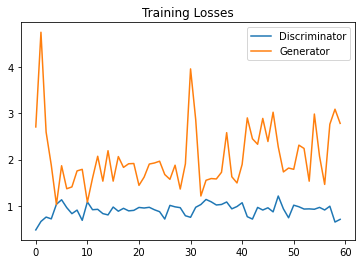

In [72]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

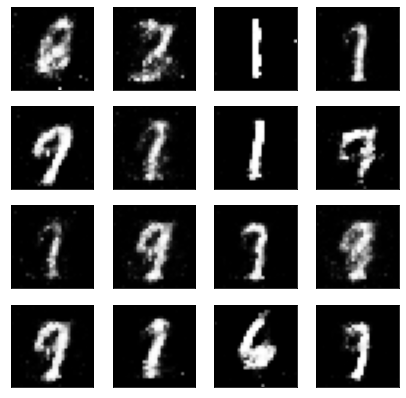

In [73]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Seguidament se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

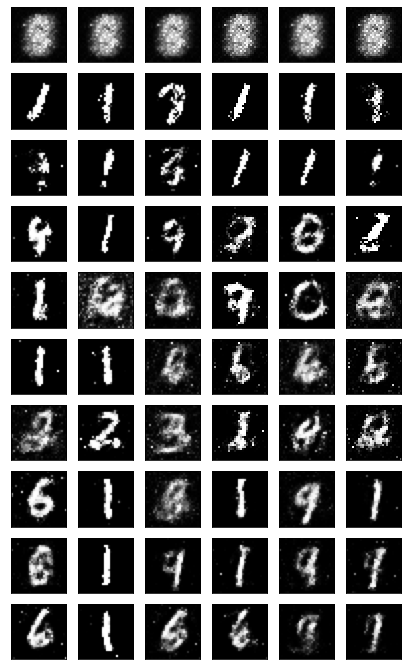

In [74]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

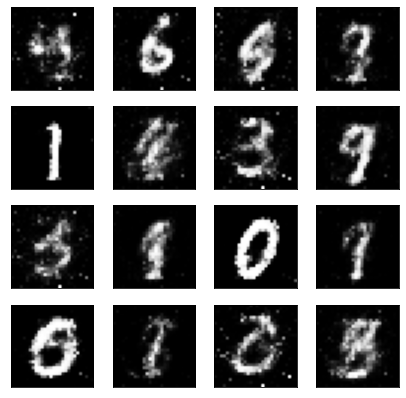

In [75]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

### Conclusiones de la segunda prueba

ESCRIBIR AQUÍÍÍÍÍ

---

## Training de la tercera prueba

Vamos a usar:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 16 (con el número de neuronas múltiple a 16)
- Dropout del 0.40
- Epocas 80
- Learning rate 0.001

In [76]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 16

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 16

# Probabilidad de dropout
p = 0.40

In [77]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=128, bias=True)
  (capa_oculta2): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=32, bias=True)
  (capa_oculta4): Linear(in_features=32, out_features=16, bias=True)
  (capa_output): Linear(in_features=16, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=16, bias=True)
  (capa_oculta2): Linear(in_features=16, out_features=32, bias=True)
  (capa_oculta3): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=128, bias=True)
  (capa_salida): Linear(in_features=128, out_features=784, bias=True)
)


In [78]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [79]:
# training hyperparams
num_epochs = 80 

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Train with real images
        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   80] | d_loss: 1.3756 | g_loss: 0.8443
Epoch [    1/   80] | d_loss: 0.7711 | g_loss: 4.0143
Epoch [    1/   80] | d_loss: 1.1337 | g_loss: 0.8207
Epoch [    2/   80] | d_loss: 1.3917 | g_loss: 0.7777
Epoch [    2/   80] | d_loss: 1.2728 | g_loss: 1.0090
Epoch [    2/   80] | d_loss: 0.9264 | g_loss: 1.5987
Epoch [    3/   80] | d_loss: 1.0494 | g_loss: 1.5022
Epoch [    3/   80] | d_loss: 1.3270 | g_loss: 1.1797
Epoch [    3/   80] | d_loss: 1.0426 | g_loss: 1.3526
Epoch [    4/   80] | d_loss: 0.9823 | g_loss: 1.7999
Epoch [    4/   80] | d_loss: 1.1940 | g_loss: 1.1839
Epoch [    4/   80] | d_loss: 1.2352 | g_loss: 0.9041
Epoch [    5/   80] | d_loss: 1.2349 | g_loss: 1.0747
Epoch [    5/   80] | d_loss: 1.3295 | g_loss: 0.8009
Epoch [    5/   80] | d_loss: 1.2244 | g_loss: 1.0317
Epoch [    6/   80] | d_loss: 1.0348 | g_loss: 1.2015
Epoch [    6/   80] | d_loss: 1.2648 | g_loss: 1.0108
Epoch [    6/   80] | d_loss: 1.2638 | g_loss: 1.0618
Epoch [    7/   80] | d_loss

### Training loss

Vamos a plotear la evolución del coste durante el entrenamiento

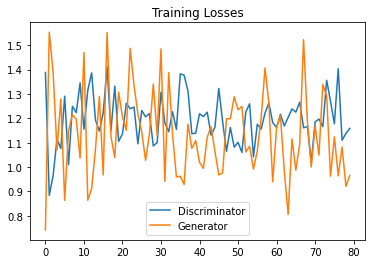

In [80]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

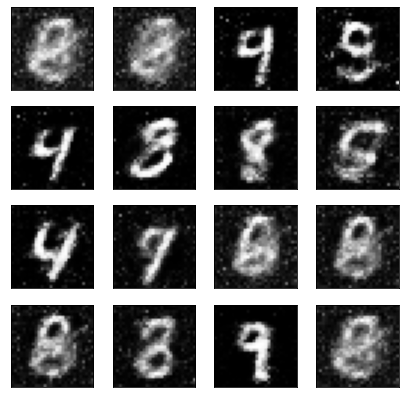

In [81]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Seguidament se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

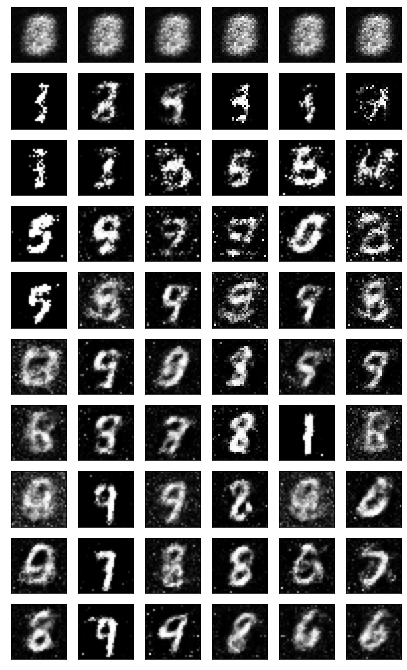

In [82]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

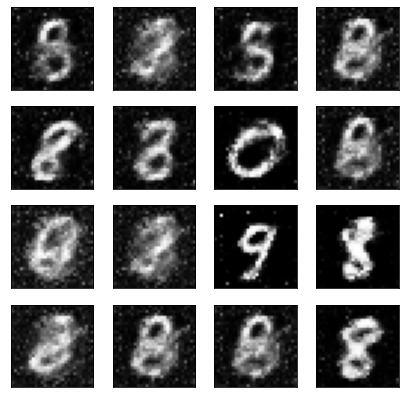

In [83]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

### Conclusiones de la tercera prueba

ESCRIBIR AQUÍÍÍÍÍ

---

## Training de la cuarta prueba

Vamos a usar:
- 4 capas ocultas por cada red
- Capas con tamaños múltiples a 16 (con el número de neuronas múltiple a 16)
- Dropout del 0.40
- Epocas 100
- Learning rate 0.004

In [92]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 16

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 16

# Probabilidad de dropout
p = 0.40

In [93]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=128, bias=True)
  (capa_oculta2): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=32, bias=True)
  (capa_oculta4): Linear(in_features=32, out_features=16, bias=True)
  (capa_output): Linear(in_features=16, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=16, bias=True)
  (capa_oculta2): Linear(in_features=16, out_features=32, bias=True)
  (capa_oculta3): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta4): Linear(in_features=64, out_features=128, bias=True)
  (capa_salida): Linear(in_features=128, out_features=784, bias=True)
)


In [94]:
# Definimos el learning rate
lr = 0.001

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [95]:
# training hyperparams
num_epochs = 100 

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Train with real images
        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3997 | g_loss: 0.6373
Epoch [    1/  100] | d_loss: 1.0719 | g_loss: 1.8095
Epoch [    1/  100] | d_loss: 1.2788 | g_loss: 1.0439
Epoch [    2/  100] | d_loss: 1.3535 | g_loss: 0.9251
Epoch [    2/  100] | d_loss: 0.6645 | g_loss: 2.1852
Epoch [    2/  100] | d_loss: 0.8868 | g_loss: 1.9688
Epoch [    3/  100] | d_loss: 1.1020 | g_loss: 1.2264
Epoch [    3/  100] | d_loss: 0.9705 | g_loss: 1.7953
Epoch [    3/  100] | d_loss: 1.1067 | g_loss: 1.5143
Epoch [    4/  100] | d_loss: 1.1227 | g_loss: 1.0843
Epoch [    4/  100] | d_loss: 1.0432 | g_loss: 1.2621
Epoch [    4/  100] | d_loss: 1.2688 | g_loss: 0.8883
Epoch [    5/  100] | d_loss: 1.4075 | g_loss: 1.2744
Epoch [    5/  100] | d_loss: 1.2279 | g_loss: 1.1824
Epoch [    5/  100] | d_loss: 1.1886 | g_loss: 1.0145
Epoch [    6/  100] | d_loss: 1.2434 | g_loss: 0.9490
Epoch [    6/  100] | d_loss: 1.2844 | g_loss: 0.9020
Epoch [    6/  100] | d_loss: 1.2653 | g_loss: 1.0171
Epoch [    7/  100] | d_loss

### Training loss

Vamos a plotear la evolución del coste durante el entrenamiento

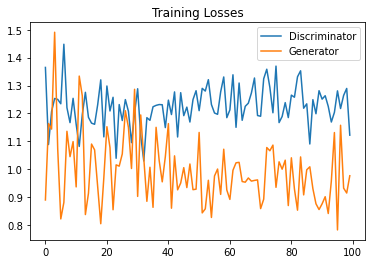

In [96]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

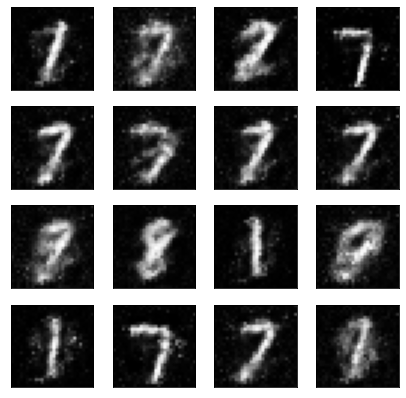

In [97]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Seguidament se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

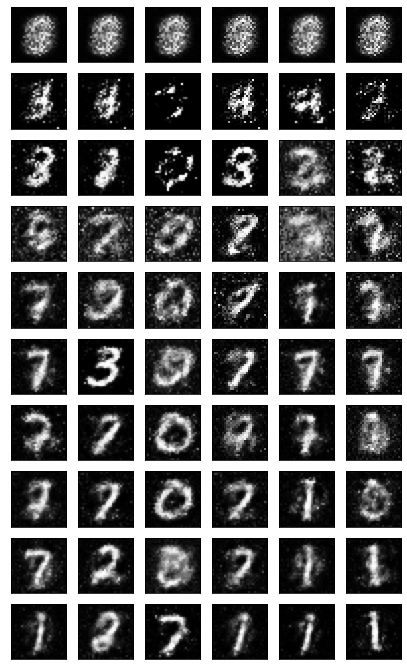

In [98]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

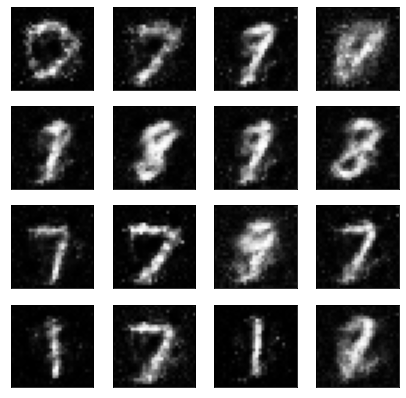

In [99]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

### Conclusiones de la cuarta prueba

ESCRIBIR AQUÍÍÍÍÍ

---

## Training de la quinta prueba

Vamos a usar:
- 3 capas ocultas por cada red
- Capas con tamaños múltiples a 32 (con el número de neuronas múltiple a 32)
- Dropout del 0.25
- Epocas 60
- Learning rate 0.002


### Discriminador

In [105]:
# Definimos la clase que generará la red neuronal artifical encargada de discriminar si los datos son reales o falsos.

class Discriminator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal). 
    
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        
        super(Discriminator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene muchas neuronas en las
        # primeras capas y que va disminuyendo, de tamaño, paulativamente. 
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim * 4)  
        self.capa_oculta2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.capa_oculta3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.capa_output = nn.Linear(hidden_dim, output_size)
        
        self.p = p 

    # Definimos la función feedforward de la red
    def forward(self, x):
        
        # Aplanamos la imagen (que esta en formato de tensor) mediante la función view de pytorch.
        x = x.view(-1,28*28)
        # x = x.flatten(28*28)        
        
        # Pasamos la imagen aplanada por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido de pasar la imagen por la función de propagación lineal le aplicamos 
        # la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Pasamos la imagen por la capa de salida sin aplicarle, aún, la función de activación (tal y como
        # indica el enunciado).
        x = self.capa_output(x)

        return x

### Generador

In [106]:
# Definimos la clase que generará la red neuronal artifical que generará datos falsos.

class Generator(nn.Module):

    # Definimos la arquitectura de la red neuronal artificial. Definimos la cantidad de capas ocultas 
    # que tiene la red, su tamaño y su función de propagación (la cual será lineal tal y como indica el
    # enunciado). También definimos la capa oculta y su función de propagación (también lineal).
    def __init__(self, input_size, hidden_dim, output_size, p = 0.0):
        super(Generator, self).__init__()
        
        # Siguiendo el esquema visto en la clase de teoria construimos una red que tiene pocas neuronas en las
        # primeras capas y que va aumentando, de tamaño, paulativamente.
        self.capa_oculta1 = nn.Linear(input_size, hidden_dim)
        self.capa_oculta2 = nn.Linear(hidden_dim , hidden_dim * 2)
        self.capa_oculta3 = nn.Linear(hidden_dim * 2 , hidden_dim * 4)
        self.capa_salida = nn.Linear(hidden_dim * 4, output_size)
        
        self.p = p
    
    # Definimos la función feedforward de la red.
    def forward(self, x):

        # Pasamos los datos (imágenes) por cada capa oculta de la red neuronal que hemos definido anteriormente. 
        # Además al resultado obtenido por pasar los datos por la función de propagación lineal de cada red le
        # aplicamos la función LeakyReLU.
        x = F.leaky_relu(self.capa_oculta1(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta2(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        x = F.leaky_relu(self.capa_oculta3(x), 0.01)
        x = F.dropout(x, p = self.p, training = self.training)
        
        # Al resultado de aplicar la capa de salida (función de propagación lineal) a los datos le aplicamos 
        # la función de la tangente hiperbólica como función de activación.
        x = torch.tanh(self.capa_salida(x))
                
        return x
    

In [107]:
# Hiper-parámetros del discriminador

# Tamaño de la imagen de entrada al discriminador (28*28)
input_size = 784
# Tamaño de la salida del discriminador (real o falsa) 
d_output_size = 1
# Tamaño de la última capa oculta del discriminador 
d_hidden_size = 32

# Hiper-parámetros de la generadora

# Tamaño de la imagen de entrada a la generadora
z_size = 100
# Tamaño de la salida de la generadora (28*28)
g_output_size = 784
# Tamaño de la primera capa oculta de la generadora
g_hidden_size = 32

# Probabilidad de dropout
p = 0.25

In [108]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size, p)
G = Generator(z_size, g_hidden_size, g_output_size, p)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (capa_oculta1): Linear(in_features=784, out_features=128, bias=True)
  (capa_oculta2): Linear(in_features=128, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=32, bias=True)
  (capa_output): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (capa_oculta1): Linear(in_features=100, out_features=32, bias=True)
  (capa_oculta2): Linear(in_features=32, out_features=64, bias=True)
  (capa_oculta3): Linear(in_features=64, out_features=128, bias=True)
  (capa_salida): Linear(in_features=128, out_features=784, bias=True)
)


In [109]:
# Definimos el learning rate
lr = 0.002

# Aplicamos el optimizador Adam 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [110]:
# training hyperparams
num_epochs = 50 

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        #TO-DO
        
        d_optimizer.zero_grad()
            
            
        # 1. Train with real images
        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth = True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        #TO-DO
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        #TO-DO
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake, False)
        
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3671 | g_loss: 0.7348
Epoch [    1/   50] | d_loss: 0.5184 | g_loss: 4.5962
Epoch [    1/   50] | d_loss: 0.9312 | g_loss: 1.9283
Epoch [    2/   50] | d_loss: 0.8922 | g_loss: 2.4969
Epoch [    2/   50] | d_loss: 1.0729 | g_loss: 2.8246
Epoch [    2/   50] | d_loss: 1.4680 | g_loss: 0.9046
Epoch [    3/   50] | d_loss: 0.9753 | g_loss: 1.7213
Epoch [    3/   50] | d_loss: 1.1395 | g_loss: 2.2667
Epoch [    3/   50] | d_loss: 1.2158 | g_loss: 1.1739
Epoch [    4/   50] | d_loss: 1.2844 | g_loss: 1.6298
Epoch [    4/   50] | d_loss: 0.7414 | g_loss: 2.4705
Epoch [    4/   50] | d_loss: 1.0066 | g_loss: 1.1411
Epoch [    5/   50] | d_loss: 0.9971 | g_loss: 1.8469
Epoch [    5/   50] | d_loss: 1.0649 | g_loss: 1.2222
Epoch [    5/   50] | d_loss: 1.1988 | g_loss: 1.4056
Epoch [    6/   50] | d_loss: 1.1010 | g_loss: 1.1896
Epoch [    6/   50] | d_loss: 1.0534 | g_loss: 1.0605
Epoch [    6/   50] | d_loss: 1.0434 | g_loss: 2.3864
Epoch [    7/   50] | d_loss

### Training loss

Vamos a plotear la evolución del coste durante el entrenamiento

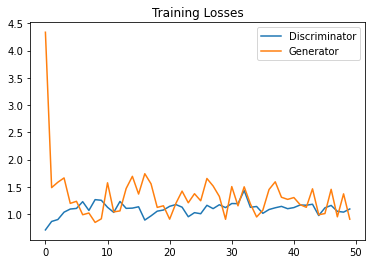

In [111]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Muestras de números obtenidas durante el entrenamiento

A continuación podemos ver muestras de imágenes que ha ido generando el generador durante el entrenamiento.

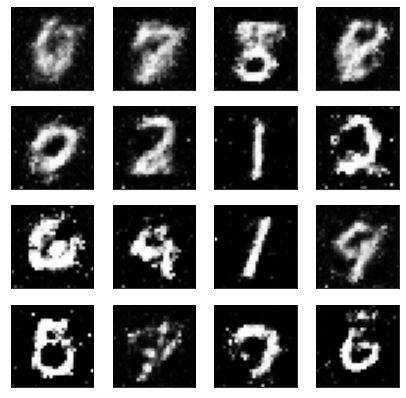

In [112]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Seguidament se muestran las imágenes generadas, mientras la red se estaba entrenando, cada 10 épocas.

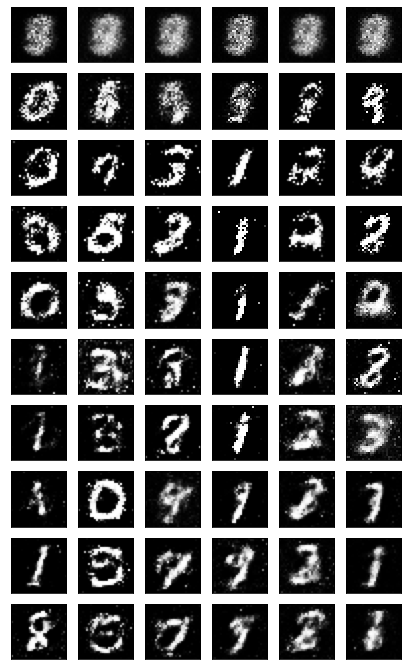

In [113]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Nuevas imágenes generadas por el generador

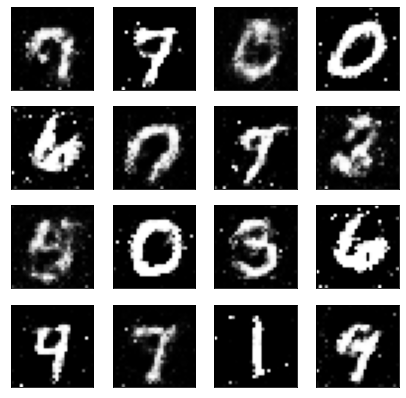

In [114]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])